In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv('/Users/rampageyao/Desktop/tum/applied machine intelligence/project/elec_forecast.csv')

Price = data['Spot price']
Date = data['Date']

data = data.drop(['Spot price','Date'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56220 entries, 0 to 56219
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time of day                56220 non-null  int64  
 1   Biomass[MWh]               56124 non-null  float64
 2   Hydropower[MWh]            56124 non-null  float64
 3   Wind offshore[MWh]         56144 non-null  float64
 4   Wind onshore[MWh]          56143 non-null  float64
 5   Photovoltaics[MWh]         56120 non-null  float64
 6   Other renewable[MWh]       56124 non-null  float64
 7   Nuclear[MWh]               56124 non-null  float64
 8   Fossil brown coal[MWh]     56148 non-null  float64
 9   Fossil hard coal[MWh]      56124 non-null  float64
 10  Fossil gas[MWh]            56124 non-null  float64
 11  Hydro pumped storage[MWh]  56124 non-null  float64
 12  Other conventional[MWh]    56124 non-null  float64
 13  Total[MWh]                 56220 non-null  flo

In [3]:
data = data.fillna(method="bfill")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56220 entries, 0 to 56219
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time of day                56220 non-null  int64  
 1   Biomass[MWh]               56220 non-null  float64
 2   Hydropower[MWh]            56220 non-null  float64
 3   Wind offshore[MWh]         56220 non-null  float64
 4   Wind onshore[MWh]          56220 non-null  float64
 5   Photovoltaics[MWh]         56220 non-null  float64
 6   Other renewable[MWh]       56220 non-null  float64
 7   Nuclear[MWh]               56220 non-null  float64
 8   Fossil brown coal[MWh]     56220 non-null  float64
 9   Fossil hard coal[MWh]      56220 non-null  float64
 10  Fossil gas[MWh]            56220 non-null  float64
 11  Hydro pumped storage[MWh]  56220 non-null  float64
 12  Other conventional[MWh]    56220 non-null  float64
 13  Total[MWh]                 56220 non-null  flo

Text(0, 0.5, 'Cumulative Explained Variance')

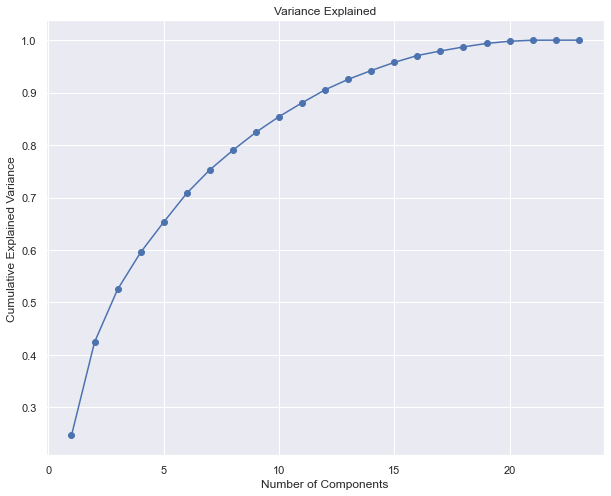

In [4]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data)

pca = PCA()
pca.fit(segmentation_std)
plt.figure(figsize=(10,8))
plt.plot(range(1,24), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='-')
plt.title('Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# select components that VAR higher than 0.8
# here: 9

In [5]:
pca = PCA(n_components=9)
pca.fit(segmentation_std)
scores_pca = pca.transform(segmentation_std)
data_pca = pd.concat([data.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_pca.columns.values[-9: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9']
df = data_pca[['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9']]
df['Date'] = Date
df['Spot price'] = Price
df.head()

<ipython-input-5-aace26a87519>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = Date
<ipython-input-5-aace26a87519>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spot price'] = Price


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Date,Spot price
0,-1.924189,1.202673,3.567820,-0.908579,-1.194695,-0.666610,0.512972,-0.887914,-0.463853,2015/1/1,25.02
1,-1.783566,1.059597,4.050806,-0.980122,-0.965624,-0.790340,0.111431,-0.916740,-0.702750,2015/1/1,18.29
2,-1.652698,0.961342,4.350747,-0.929024,-0.805963,-0.831601,0.181863,-1.168401,-0.950777,2015/1/1,16.04
3,-1.613076,0.864001,4.469641,-1.002482,-0.669927,-0.876909,-0.024458,-1.211492,-1.115990,2015/1/1,14.60
4,-1.621573,0.892460,4.403029,-0.946070,-0.662277,-0.841313,0.118173,-1.214763,-1.172488,2015/1/1,14.95


In [6]:
df.set_index("Date", drop=False, inplace=True)
df.reset_index(drop=True, inplace=True)
lag_features = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9']
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]


df.set_index("Date", drop=False, inplace=True)
df.fillna(df.mean(), inplace=True)
df.head()


<ipython-input-6-a168a16527f6>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
<ipython-input-6-a168a16527f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
<ipython-input-6-a168a16527f6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Date,...,Component 8_mean_lag30,Component 8_std_lag3,Component 8_std_lag7,Component 8_std_lag30,Component 9_mean_lag3,Component 9_mean_lag7,Component 9_mean_lag30,Component 9_std_lag3,Component 9_std_lag7,Component 9_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2015/1/1,-1.924189,1.202673,3.567820,-0.908579,-1.194695,-0.666610,0.512972,-0.887914,-0.463853,2015/1/1,...,-0.000165,0.078103,0.132748,0.247837,0.000027,0.000021,-0.000206,0.161610,0.288351,0.555447
2015/1/1,-1.783566,1.059597,4.050806,-0.980122,-0.965624,-0.790340,0.111431,-0.916740,-0.702750,2015/1/1,...,-0.887914,0.078103,0.132748,0.247837,-0.463853,-0.463853,-0.463853,0.161610,0.288351,0.555447
2015/1/1,-1.652698,0.961342,4.350747,-0.929024,-0.805963,-0.831601,0.181863,-1.168401,-0.950777,2015/1/1,...,-0.902327,0.020383,0.020383,0.020383,-0.583302,-0.583302,-0.583302,0.168926,0.168926,0.168926
2015/1/1,-1.613076,0.864001,4.469641,-1.002482,-0.669927,-0.876909,-0.024458,-1.211492,-1.115990,2015/1/1,...,-0.991018,0.154293,0.154293,0.154293,-0.705793,-0.705793,-0.705793,0.243476,0.243476,0.243476
2015/1/1,-1.621573,0.892460,4.403029,-0.946070,-0.662277,-0.841313,0.118173,-1.214763,-1.172488,2015/1/1,...,-1.046137,0.159201,0.167401,0.167401,-0.923173,-0.808343,-0.808343,0.207998,0.285632,0.285632


In [7]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

<ipython-input-7-aaf895c467cb>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Date,...,Component 9_mean_lag3,Component 9_mean_lag7,Component 9_mean_lag30,Component 9_std_lag3,Component 9_std_lag7,Component 9_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015/1/1,-1.924189,1.202673,3.567820,-0.908579,-1.194695,-0.666610,0.512972,-0.887914,-0.463853,2015-01-01,...,0.000027,0.000021,-0.000206,0.161610,0.288351,0.555447,1,1,1,3
2015/1/1,-1.783566,1.059597,4.050806,-0.980122,-0.965624,-0.790340,0.111431,-0.916740,-0.702750,2015-01-01,...,-0.463853,-0.463853,-0.463853,0.161610,0.288351,0.555447,1,1,1,3
2015/1/1,-1.652698,0.961342,4.350747,-0.929024,-0.805963,-0.831601,0.181863,-1.168401,-0.950777,2015-01-01,...,-0.583302,-0.583302,-0.583302,0.168926,0.168926,0.168926,1,1,1,3
2015/1/1,-1.613076,0.864001,4.469641,-1.002482,-0.669927,-0.876909,-0.024458,-1.211492,-1.115990,2015-01-01,...,-0.705793,-0.705793,-0.705793,0.243476,0.243476,0.243476,1,1,1,3
2015/1/1,-1.621573,0.892460,4.403029,-0.946070,-0.662277,-0.841313,0.118173,-1.214763,-1.172488,2015-01-01,...,-0.923173,-0.808343,-0.808343,0.207998,0.285632,0.285632,1,1,1,3


In [8]:
df_train = df[51875:56119] # 改
df_valid = df[56119:56219]

In [9]:
df_temp = df.drop(['Date', 'Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9'], axis='columns')

In [10]:
# 'Time of day',
exogenous_features = df_temp.columns[df_temp.columns != 'Spot price']

In [11]:
model = auto_arima(df_train['Spot price'], exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train['Spot price'], exogenous=df_train[exogenous_features])

evidence = model.predict(n_periods=len(df_train), exogenous=df_train[exogenous_features])
df_train["Train_ARIMAX"] = evidence

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26159.200, Time=27.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26798.339, Time=1.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26620.047, Time=23.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26570.200, Time=23.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26796.355, Time=7.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26191.096, Time=24.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26154.609, Time=24.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26567.192, Time=24.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26487.291, Time=24.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26158.100, Time=25.49 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26378.451, Time=24.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=26.60 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26102.623, Time=22.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26564.816, Time=23.85 sec
 ARIMA(2,1,0)

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-11-fe6f0dd327a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Train_ARIMAX"] = evidence
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-11-fe6f0dd327a3>:8: SettingWithCopyWarning: 
A value is trying to be set on 

Text(0.5, 1.0, 'Forecast')

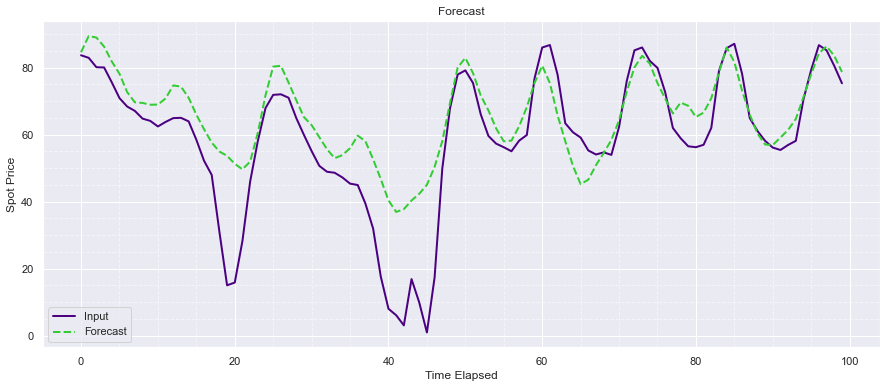

In [12]:
y = df_valid["Forecast_ARIMAX"].tolist()
#print(len(y))

#print(df[df.Date > "2015/12/31"].iloc[:,5])
#x = df[df.Date > "2015/12/31"].iloc[:,5]
x = list(range(0,len(y)))
#print(x)

plt.figure(figsize=(15,6))
plt.rcParams.update({"font.size" : 16})

plt.plot(x, df_valid["Spot price"], '-', color = 'indigo', label = 'Input', linewidth=2)
plt.plot(x, df_valid["Forecast_ARIMAX"],'--', color = 'limegreen', label = 'Forecast', linewidth=2)

#formatting
plt.grid(b=True, which='major', linestyle = 'solid')
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
plt.xlabel("Time Elapsed")
plt.ylabel("Spot Price")
plt.legend()
plt.title("Forecast")

In [13]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid['Spot price'], df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid['Spot price'], df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 12.95274152650851

MAE of Auto ARIMAX: 8.870653258336967


In [14]:
predict = df_valid.Forecast_ARIMAX.tolist()
actual = df_valid['Spot price'].tolist()
print(predict)
print(actual)

[84.58905407770071, 89.43149242881138, 88.95281397858956, 86.26335615744517, 81.8099809521969, 78.15000420359738, 72.67640064784324, 69.63015661555028, 69.44962999096887, 68.90612842840126, 68.95255509172904, 70.78079263542911, 74.67049419974492, 74.32220910158662, 70.97742285814674, 65.95055697071638, 61.60473590877291, 57.60631491180198, 54.943044332894786, 53.65230610736397, 51.26995452031252, 49.623648520685286, 51.92175344133467, 60.51481950938515, 71.71326800639756, 80.28748868976037, 80.5221293015796, 75.52954787531424, 70.26413784923803, 65.22126802782579, 62.827357599205996, 59.22479684792322, 55.62792756908383, 52.9559432170223, 53.865792651472894, 55.92171208923329, 59.686593797364, 58.01199402812436, 52.64759134206051, 46.70670726763372, 40.36824254884061, 36.90672546387368, 37.74574263806242, 40.32378731774329, 42.31330517684791, 45.009329535377475, 50.3666696089855, 58.01563198635731, 69.39132756980385, 79.99699965733846, 82.88051379102104, 78.33997380869789, 71.686959219

In [15]:
from sklearn.metrics import mean_absolute_percentage_error
print(1 - mean_absolute_percentage_error(predict, actual))

0.8371886845497871


Potential improvement:

1. add missing values for labels (regression to fill missing values written by Yuqicheng Zhu)
2. might try fancier missing value filling method for raw features instead of "bfill"
3. might try fancier missing value filling method for exogenous features instead of "mean" (wouldn't have big impact)
4. might try other window sizes